## Initial Configuration
Some setup before building and running the model

In [ ]:
# some basic things to include
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

# some preprocessing techniques
from scipy.fftpack import dct

# this is only required for Google Colab
from google.colab import drive

In [ ]:
!gdown --id 1gjbSZV5NjjIVOqSP-yTCqXcGPX9PnYn5
!unzip -q '/content/MM17-WeiboRumorSet.zip'

Downloading...
From: https://drive.google.com/uc?id=1gjbSZV5NjjIVOqSP-yTCqXcGPX9PnYn5
To: /content/MM17-WeiboRumorSet.zip
1.35GB [00:18, 74.4MB/s]


In [ ]:
dataset = datasets.ImageFolder(mainfolder) 
print(dataset[0])


(<PIL.Image.Image image mode=RGB size=440x222 at 0x7FA88E639128>, 0)


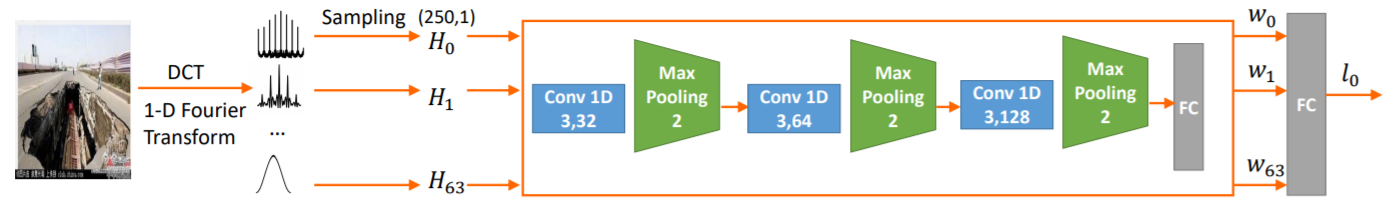

## DCT and DFT

DCT will be used to preprocess the input data. \
We want to retrieve information in the frequency domain, rather than pixels.

After that, we apply DFT to get the frequency information of frequency domain.

In [ ]:
'''
Usage:
as image preprocessor by calling DCT() as a transform

input: 128*128*3 PIL image
output: 64*256 torch array (histogram)

[128*128] => (crop) => [256 * [8*8]] => (DCT_2d) => [256 * [8 * 8]] => reshape => [256 * 64]  
'''
class DCT(object):
    def __init__(self):
        self.BLOCK_HEIGHT = 8
        self.BLOCK_WIDTH = 8
        self.BLOCK_SIZE = (self.BLOCK_HEIGHT, self.BLOCK_WIDTH)

    def div_block(self, img, block_size):
        img_height = img.height
        img_width = img.width
        block_height = block_size[0]
        block_width = block_size[1]
        assert(img_height % block_height == 0)
        assert(img_width % block_width == 0)

        blocks = []
        for i in range(0,img_height,block_height):
            for j in range(0,img_width,block_width):
                box = (j, i, j+block_width, i+block_height)
                block = np.array(img.crop(box))
                blocks.append(block)
        return np.array(blocks)

    def dct2(self, array_2d):
        return dct(dct(array_2d.T, norm = 'ortho').T, norm = 'ortho')

    def _dct2(self, array_2d):
        return dct(dct(array_2d, norm = 'ortho').T, norm = 'ortho').T

    def __call__(self, img):
        image = img
        blocks = self.div_block(image, self.BLOCK_SIZE)
        Y_blocks, Cb_blocks, Cr_blocks = blocks[:, :, :, 0], blocks[:, :, :, 1], blocks[:, :, :, 2]
        # test_blocks = (b_blocks + g_blocks + r_blocks) / 3 # naive greyscale
        result = np.array([self._dct2(Y_block) for Y_block in Y_blocks])
        # return a torch.tensor
        return torch.from_numpy(result.reshape(256, 64).T).float()

    def __repr__(self):
        return "Simply DCT. What do you expect?"

'''
Usage: Same as DCT()

input: 64*256 torch array (histogram)
output: 64*256 torch array (frequency histogram)
'''
class DFT(object):
    def __init__(self):
        pass

    def __call__(self, freq):
        # convert into complex form containing real and imaginary part
        cmplx = torch.from_numpy(np.zeros((freq.shape[0], freq.shape[1], 2)))
        cmplx[:, :, 0] += freq
        out = torch.fft(cmplx, 1)[:, :, 0]
        return out

    def __repr__(self):
        return "Simply DFT. What do you expect?"

## Trainging/Test Data Loading

We use the DCT defined above as one of our preprocess step.

In [ ]:
def image_show(np_image):
    plt.figure(figsize = (5,5))
    plt.imshow(np_image) # it should be a numpy array
    plt.show()

# mainfolder = 'drive/My Drive/COMP5331 Fall 2020/MM17-WeiboRumorSet/'
mainfolder = 'MM17-WeiboRumorSet/'
image_height = 128
image_width  = 128
mytransform = transforms.Compose([
    transforms.Resize((image_height,image_width), interpolation=Image.NEAREST),
    DCT(),
    # DFT()
])

def YCbCr_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('YCbCr')

dataset = datasets.ImageFolder(mainfolder, transform=mytransform, loader=YCbCr_loader)
# NOTE: The path should point to a place with subfolders (which contain images inside).
#  It will report bugs if there is no subfolder.
# print(type(dataset))
print('Total no. of images: ', len(dataset))

# print(f"[debug]: {dataset[0][0].shape}")
# print(f"[debug]: {dataset[0][0]}")

# 80% train, 20% test
trainset, testset = torch.utils.data.random_split(dataset, [round(len(dataset)*0.8), round(len(dataset)*0.2)])
print('Total no. of train set images: ', len(trainset))
print('Total no. of test set images: ', len(testset))

labels = dataset.class_to_idx # the dataset saves the subfolder's name as the labels
# print(labels) 
# print(type(labels))

classes = list(labels.keys()) # convert dict keys into list
print('classes:', classes)

Total no. of images:  13249
Total no. of train set images:  10599
Total no. of test set images:  2650
classes: ['nonrumor_images', 'rumor_images', 'tweets']


In [ ]:
batch_size = 32

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True) 
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True) 

## Attention

At some point I realize attention is not going to work for single vector. \\
So maybe we can add it back after integration.

## Frequency Domain Subnetwork

Basically, this is the model to train

In [ ]:
class Frequent_Domain_Subnetwork(nn.Module):
    def __init__(self):
        super(Frequent_Domain_Subnetwork, self).__init__()
        self.backbone = nn.Sequential(nn.Conv1d(64, 32, 3, padding=1),
                             nn.MaxPool1d(2),
                             nn.Conv1d(32, 64, 3, padding=1),
                             nn.MaxPool1d(2),
                             nn.Conv1d(64, 128, 3, padding=1),
                             nn.MaxPool1d(2),
                             nn.Flatten(),
                             nn.Linear(4096, 64),
                             nn.ReLU(),
                             nn.Linear(64, 2))

    def forward(self, x):
        out = self.backbone.forward(x)
        return out    

## Let's Start Training

In [ ]:
MAX_EPOCH = 8
print_every = 20

device = 'cpu'
model = Frequent_Domain_Subnetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
for epoch in range(MAX_EPOCH):
    total_loss, total_acc = 0, 0
    cnt = 0
    for i, data in enumerate(trainloader):
        X, y = data[0].float().to(device), data[1].to(device)
        optimizer.zero_grad() 
       
        # forward
        out = model(X)        
        #print(out, y_pred)
        loss = criterion(out, y)

        # backward
        loss.backward()
        optimizer.step()

        # stats
        y_pred = torch.argmax(out, dim=1)
        total_acc += (y_pred == y).sum().item() / len(y_pred)
        total_loss += loss.item()

        cnt += 1
        if (i+1) % print_every == 0:
            avg_loss = total_loss / cnt
            avg_acc = total_acc / cnt
            total_acc, total_loss = 0, 0
            cnt = 0
            # print(out.T, '\n', y_pred.T, '\n', y.T)
            print('[Epoch %d Iter %d] Loss: %5f  Acc: %5f' % (epoch+1, i+1, avg_loss, avg_acc))

# save the model somewhere
torch.save(model.state_dict(), "model")

[Epoch 1 Iter 20] Loss: 2.751856  Acc: 0.535937
[Epoch 1 Iter 40] Loss: 0.972949  Acc: 0.537500
[Epoch 1 Iter 60] Loss: 0.791684  Acc: 0.562500
[Epoch 1 Iter 80] Loss: 0.767047  Acc: 0.570312
[Epoch 1 Iter 100] Loss: 0.801646  Acc: 0.565625
[Epoch 1 Iter 120] Loss: 0.777211  Acc: 0.582812
[Epoch 1 Iter 140] Loss: 0.768488  Acc: 0.575000
[Epoch 1 Iter 160] Loss: 0.697080  Acc: 0.600000
[Epoch 1 Iter 180] Loss: 0.681185  Acc: 0.601562
[Epoch 1 Iter 200] Loss: 0.723280  Acc: 0.579688
[Epoch 1 Iter 220] Loss: 0.696682  Acc: 0.578125
[Epoch 1 Iter 240] Loss: 0.723635  Acc: 0.578125
[Epoch 1 Iter 260] Loss: 0.670485  Acc: 0.593750
[Epoch 1 Iter 280] Loss: 0.703359  Acc: 0.601562
[Epoch 1 Iter 300] Loss: 0.701795  Acc: 0.576562
[Epoch 1 Iter 320] Loss: 0.657741  Acc: 0.595313
[Epoch 2 Iter 20] Loss: 0.669653  Acc: 0.595313
[Epoch 2 Iter 40] Loss: 0.609605  Acc: 0.631250
[Epoch 2 Iter 60] Loss: 0.627169  Acc: 0.609375
[Epoch 2 Iter 80] Loss: 0.622227  Acc: 0.645312
[Epoch 2 Iter 100] Loss: 0.6

## Test

run the following block if you want the model to be loaded instead of trained.

In [ ]:
model.load_state_dict(torch.load("model"))

<All keys matched successfully>

In [ ]:
from sklearn.metrics import accuracy_score # normal accuracy
from sklearn.metrics import balanced_accuracy_score # used in case of imbalanced data sets, average of recall, from 0 to 1
from sklearn.metrics import confusion_matrix # division of performance on the multilabels
from sklearn.metrics import cohen_kappa_score # compares model against random prediction, from -1 to 1
from sklearn.metrics import classification_report # for multilabel classification, gives precision, recall, f score, support, more
target_names = ['class 0', 'class 1']

def print_metrics(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Balanced Accuracy:" , balanced_accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Cohen Kappa Score:", cohen_kappa_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
report_every = 10
acc, loss = 0, 0
cnt = 0
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data in testloader:
        X, y = data[0].float().to(device), data[1].to(device)    
        # prediction
        out = model(X)        
        pred = torch.argmax(out, dim=1)

        y_true.append(y)
        y_pred.append(pred)

        cnt += 1

        if cnt % report_every == 0:
            print("[Test] %d / %d batches tested" % (cnt, testloader.__len__()))        

    print("[Test] %d / %d batches tested" % (cnt, testloader.__len__()))
    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    print_metrics(y_true, y_pred)

[Test] 10 / 83 batches tested
[Test] 20 / 83 batches tested
[Test] 30 / 83 batches tested
[Test] 40 / 83 batches tested
[Test] 50 / 83 batches tested
[Test] 60 / 83 batches tested
[Test] 70 / 83 batches tested
[Test] 80 / 83 batches tested
[Test] 83 / 83 batches tested
Accuracy: 0.7181132075471698
Balanced Accuracy: 0.699630584151476
Confusion Matrix:
 [[ 640  406]
 [ 341 1263]]
Cohen Kappa Score: 0.4036238987882377
Classification Report:
               precision    recall  f1-score   support

     class 0       0.65      0.61      0.63      1046
     class 1       0.76      0.79      0.77      1604

    accuracy                           0.72      2650
   macro avg       0.70      0.70      0.70      2650
weighted avg       0.72      0.72      0.72      2650

